In [3]:
import torch
import torch.nn as nn
import fastai.vision.all as fv

¿Qué hace fit_one_cycle?

div -> ¿Por cuánto debes dividir la learning rate al inicio?
final_div -> ¿Por cuánto debes dividir la learning rate al final?
pct_start -> ¿Cuáto calentamiento hace?

In [8]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=False,
                            max_rotate=10,
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.2)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

birds = load_data("/storage/birds", img_size=128, batch_size=64)

In [5]:
##Flatten es una capa que ayuda a pasar de la parte convolucional a la parte lineal

#Lo que hace la clase es que le pasamos algo y nos regresa eso mismo pero sin los 1
class Flatten(nn.Module):   #Creamos un módulo que hereda de nn.Module
    def __init__(self):    #Para crear un objeto
        super().__init__() #Le decimos a nn.Module que se inicie
    
    def forward( self, x ): #
        #return x.squeeze()
        return x.reshape (x.shape[0],-1) #Toma la primera y adivina el resto
        #Se agrega esta porque si el batch es de tam 1, squezze lo elimina
        

In [9]:
lx97  = nn.Sequential( #Sequential para cosas sencillas
    nn.BatchNorm2d( 3 ), #Ideal comenzar normalizando 
    #Convolucion de entrada 3, de 32 filtros, de tamaño 3x3, 
    #sride -> ¿cuánto brinca?, padding -> pone el brde negro para no perder pixeles
    nn.Conv2d( 3, 32, kernel_size = 3, stride = 2, padding = 1),
    
    #Acivacion
    nn.ReLU(),
    ##ResBlock( crear_residual( 16 ) ),
    #Reducir el tamaño de a  imagen (será más rápido)
    #Cada cuadro de 2x2 agarra el más grande.
    #Reduce a la mitad
    #nn.MaxPool2d(2),
    #nn.Conv2d( 16, 32, kernel_size=2 ),
    #nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    nn.Conv2d( 32, 32, kernel_size=2, stride = 1, padding = 1 ),
    nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    
    #Empezamos en la cantidad de filtros con los que acabamos en Conv2d anterior
    nn.Conv2d( 32, 64, kernel_size = 2, stride = 1, padding = 1),
    
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 64, 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d( 128 ),
    nn.MaxPool2d(2),
    nn.Conv2d( 128, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    nn.Conv2d( 256, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 256, 512, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 512 ),
    nn.ReLU(),
    #--Aquí acabamos con la parte convolucional--#
    
    #--Llegamos a la parte lineal--#
    
    nn.AdaptiveAvgPool2d(1), #Reducir el tamaño a 1x1xn_canales
    #Podemos usar diferentes métodos para llegar a 1x1
    Flatten(), #Usamos la funcion que habiamos creado pra eliminar las de dim 1
    #Los quita para poder usar Linear
    nn.Linear( 512, 256), #Completamente conectada
    nn.ReLU(),
    nn.Linear( 256, birds.c) #salida con el total de clases de los datos
)

In [14]:
optim = fv.partial(fv.SGD,mom=0.9)

In [18]:
learn_birds = fv.Learner( birds, lx97, opt_func=optim, metrics=fv.accuracy)#.to_fp16()

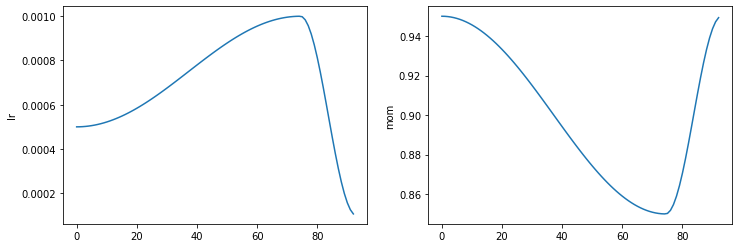

In [21]:
learn_birds.recorder.plot_sched()

Esta figura se puede controlar.

In [22]:
learn_birds.fit_one_cycle(1, 1e-3, div=2, div_final=10, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,5.272910,5.268077,0.012254,00:15


Ahora siempre usar RANGER

In [23]:
learn_birds = fv.Learner( birds, lx97, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

In [24]:
learn_birds.fit_one_cycle(1,1e-3,div=1.2,final_div=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,5.161728,5.053015,0.023473,00:18


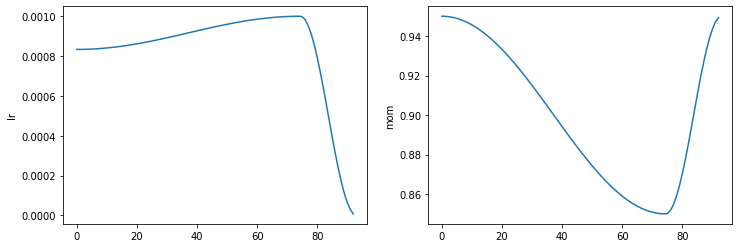

In [25]:
learn_birds.recorder.plot_sched()

Siempre usar ranger y los controladores del lr